# Visualizing the space of hypothetical zeolites using AMD distances

In [1]:
import umap
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.stats import spearmanr
from zeo_amd.plotting import savefig

plt.style.use("jupyter")

In [2]:
iza = pd.read_csv("../data/iza_nnpscan_dm.csv", index_col=0)
zfeat = pd.read_csv("../data/iza_nnpscan_features.csv", index_col=0)

hyp = pd.read_csv("../data/hyp_dm.csv", index_col=0)
hfeat = pd.read_csv("../data/hyp_features.csv", index_col=0)

In [3]:
full = pd.concat([iza, hyp], axis=0).reset_index(drop=True)
feats = pd.concat([zfeat, hfeat], axis=0).reset_index(drop=True)

In [4]:
scaler = lambda vec: (vec - iza.values.mean(0, keepdims=True)) / iza.values.std(0, keepdims=True)

In [5]:
full = pd.DataFrame(
    scaler(full.values),
    index=full.index,
    columns=full.columns
)

## Projecting the hypothetical zeolites into two dimensions using UMAP

In [6]:
def get_range(X):
    """Get range for plotting hexbins"""
    xmin, xmax = X[:, 0].min(), X[:, 0].max()
    ymin, ymax = X[:, 1].min(), X[:, 1].max()

    xrange = xmax - xmin
    yrange = ymax - ymin
    maxrange = max(xrange, yrange)
    xadd = maxrange - xrange
    yadd = maxrange - yrange

    xmin, xmax = xmin - xadd / 2, xmax + xadd / 2
    ymin, ymax = ymin - yadd / 2, ymax + yadd / 2
    
    return xmin, xmax, ymin, ymax

In [7]:
um = umap.UMAP(n_neighbors=10, random_state=42, metric="cosine")
umxy = um.fit_transform(full)

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_99649/4126033500.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f"{t:.0f}" for t in cbar.get_ticks()], fontsize=6)
/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_99649/4126033500.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels([f"{t:.0f}" for t in cbar.get_ticks()], fontsize=6)
/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_99649/4126033500.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


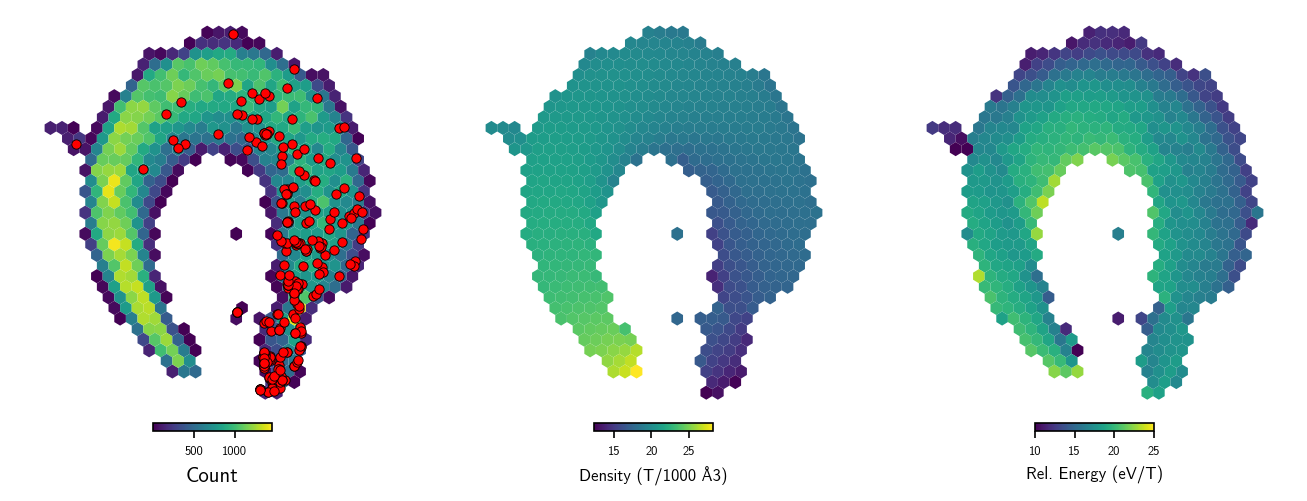

In [8]:
fig, ax_fig = plt.subplots(1, 3, figsize=(3 * 3, 3))

X = umxy
_anchor = (-0.32, -1.0, 1, 1)

ax = ax_fig[0]
hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    extent=get_range(X),
)

subX = X[:len(iza)]
ax.scatter(
    subX[:, 0],
    subX[:, 1],
    c="r",
    s=20,
    edgecolors="k",
    linewidths=0.4,
)
cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=_anchor, bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")
cbar.set_ticklabels([f"{t:.0f}" for t in cbar.get_ticks()], fontsize=6)
cbar.set_label("Count", fontsize=10)

ax = ax_fig[1]

hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    C=feats["density"],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    extent=get_range(X),
)

cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=_anchor, bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")
cbar.set_ticklabels([f"{t:.0f}" for t in cbar.get_ticks()], fontsize=6)
cbar.set_label("Density (T/1000 Å3)", fontsize=8)


ax = ax_fig[2]
norm = plt.Normalize(10, 25)

hb = ax.hexbin(
    X[:, 0], 
    X[:, 1],
    C=feats["relative_energy"],
    gridsize=31,
    linewidths=(0.,),
    mincnt=1,
    cmap="viridis",
    extent=get_range(X),
    norm=norm,
)

ticks = [10, 15, 20, 25]
cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=_anchor, bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.0f}" for t in ticks], fontsize=6)
cbar.set_label("Rel. Energy (eV/T)", fontsize=8)

for ax in ax_fig:
    ax.set_aspect("equal")
    ax.axis("off")

fig.tight_layout()
savefig(fig, "06-hyp-umap.png", dpi=300)
plt.show()

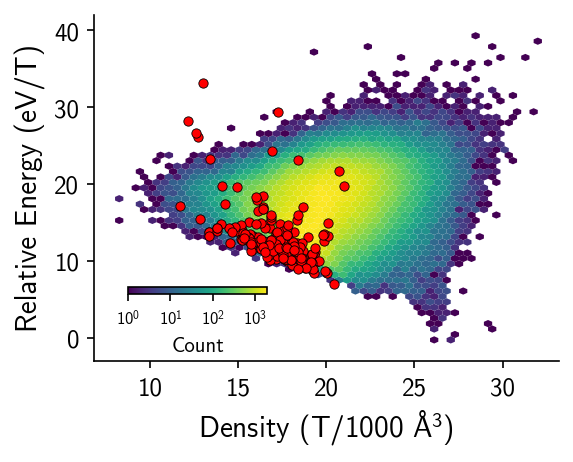

In [9]:
fig, ax = plt.subplots(figsize=(4, 3))

hb = ax.hexbin(
    hfeat["density"],
    hfeat["relative_energy"],
    gridsize=51,
    mincnt=1,
    linewidths=(0.,),
    bins="log",
    extent=(8, 32, -1, 40),
)

_z = zfeat.loc[zfeat["relative_energy"] < 50]

ax.scatter(
    _z["density"],
    _z["relative_energy"],
    c="r",
    s=20,
    edgecolors="k",
    linewidths=0.4,
)

ax.set_xlabel("Density (T/1000 Å$^3$)")
ax.set_ylabel("Relative Energy (eV/T)")

cax = inset_axes(ax, width="30%", height="2%", bbox_to_anchor=(-0.6, -0.75, 1, 1), bbox_transform=ax.transAxes)
cbar = fig.colorbar(hb, cax=cax, orientation="horizontal")

ticks = [1e0, 1e1, 1e2, 1e3]
ticklabels = ["10$^0$", "10$^1$", "10$^2$", "10$^3$"]
cbar.set_ticks(ticks)
# cbar.set_ticklabels([f"{t:.0f}" for t in ticks], fontsize=8)
cbar.set_ticklabels(ticklabels, fontsize=8)
cbar.set_label("Count", fontsize=10)

savefig(fig, "06-hyp-density.png", dpi=300)
plt.show()

## Comparing hypothetical zeolites towards each known framework

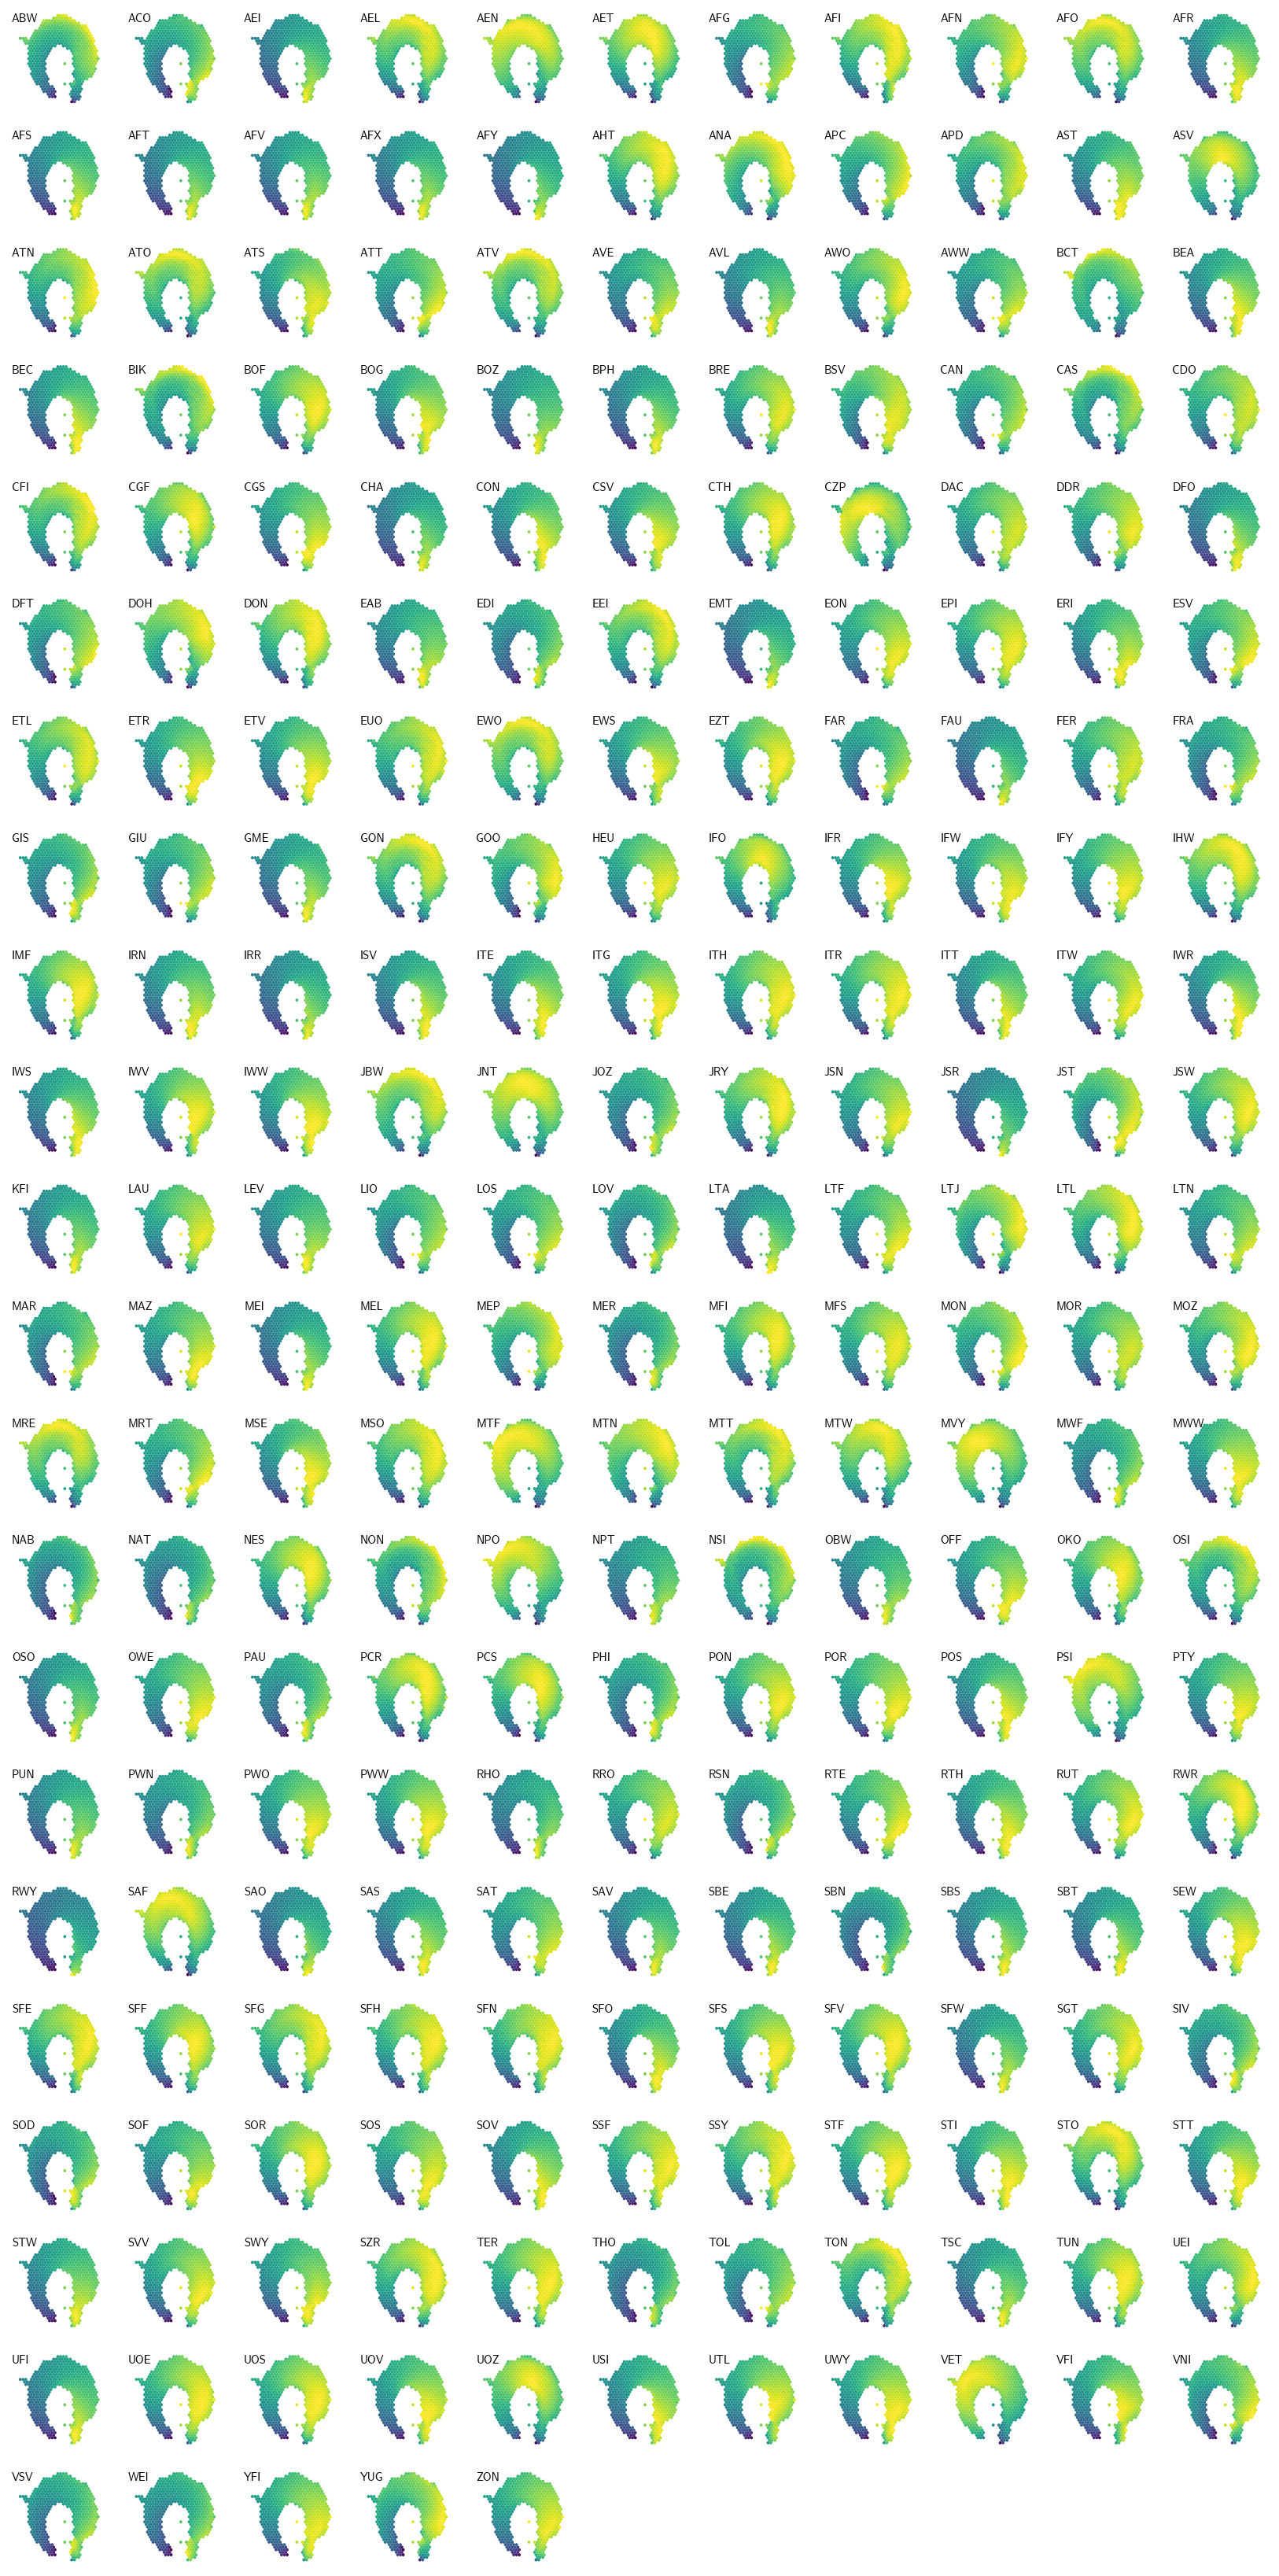

In [11]:
_labels = full.columns

COLS = 11
ROWS = np.ceil(len(_labels) / COLS).astype(int)
fig, ax_fig = plt.subplots(ROWS, COLS, figsize=(1 * COLS, 1 * ROWS), sharex=True)

X = umxy
xrange = get_range(X)
# norm = plt.Normalize(0, 1.5)

for ax, label in zip(ax_fig.reshape(-1), _labels):
    hb = ax.hexbin(
        X[:, 0], 
        X[:, 1],
        C=full[label],
        gridsize=31,
        linewidths=(0.,),
        mincnt=1,
        cmap="viridis_r",
        extent=xrange,
#         norm=norm,
    )
    ax.annotate(label, (0.0, 0.98), xycoords="axes fraction", ha="left", va="top", fontsize=7)


for ax in ax_fig.reshape(-1):
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_aspect("equal")
    ax.axis("off")

fig.tight_layout()  
savefig(fig, "06-hyp-iza.png", dpi=200)
plt.show()

## Checking the sparsity of known vs hypothetical frameworks

In [36]:
iza_pairs = iza.reset_index().melt(id_vars="index")
iza_pairs = iza_pairs.loc[iza_pairs["index"] < iza_pairs["variable"]]

In [43]:
print(iza_pairs.loc[iza_pairs.value < 0.05].sort_values("value").to_latex())

\begin{tabular}{lllr}
\toprule
{} & index & variable &     value \\
\midrule
22514 &   ITH &      ITR &  0.016311 \\
52721 &   ITG &      UOV &  0.020683 \\
43844 &   SBS &      SBT &  0.021832 \\
23929 &   ITG &      IWW &  0.025426 \\
45908 &   MEL &      SFV &  0.032423 \\
36957 &   MWF &      PAU &  0.033489 \\
45872 &   IMF &      SFV &  0.034933 \\
51536 &   IMF &      TUN &  0.034953 \\
50746 &   AFG &      TOL &  0.036960 \\
28629 &   FAR &      MAR &  0.037241 \\
49860 &   ERI &      SWY &  0.039081 \\
49947 &   OFF &      SWY &  0.040261 \\
3316  &   AFT &      AFX &  0.040369 \\
52729 &   IWW &      UOV &  0.040525 \\
8979  &   AFS &      BPH &  0.041632 \\
45266 &   SFH &      SFN &  0.041798 \\
46034 &   AFX &      SFW &  0.043873 \\
17525 &   EMT &      FAU &  0.044655 \\
50853 &   LIO &      TOL &  0.044777 \\
39576 &   PTY &      PWO &  0.045523 \\
47771 &   IWS &      SOV &  0.047217 \\
51713 &   AWO &      UEI &  0.047400 \\
53665 &   ITG &      UWY &  0.049622 \\
\bo

/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_99649/3594957961.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(iza_pairs.loc[iza_pairs.value < 0.05].sort_values("value").to_latex())


In [56]:
len(iza_pairs.loc[iza_pairs.value < 0.1].sort_values("value")["index"].unique())

105

In [57]:
print((hyp < 0.1).any(1).sum())
print(len(hyp))
print((hyp < 0.1).any(1).sum() / len(hyp))

36112
331171
0.10904336430424162


/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_99649/1431769530.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  print((hyp < 0.1).any(1).sum())
/var/folders/2q/s8z166bx6s99wf5prpd1d3q0001w6_/T/ipykernel_99649/1431769530.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  print((hyp < 0.1).any(1).sum() / len(hyp))
